### Hybrid Model

- 선형 회귀 : 추세에 대한 능력이 뛰어나다, 상호 작용을  학습할 수 없다.
- XGBoost : 상호 작용을 학습 할 수 있다, 추세를 학습 할 수 없다.
- Hybrid Model : 두 모델을 동시에 이용한다.

### **Components and Residuals**

- Componets of Series = Trend, Time Series, Cycles, Error
- Residuals( 잔차 ) = target 과 predictions 의 차이 (정답과 예측의 차이)
    - 잔차에는 모델이 학습하지 못한 부분이 포함되어 있다.

### Hybrid Forecasting with Residuals(잔차를 사용한 복합 예측)
```python
# 1. 첫번째 모델로 학습 및 예측
model_1.fit(X_train_1, y_train)
y_pred_1 = model_1.predict(X_train)

# 2. 두번째 모델로 잔차 학습 및 예측
model_2.fit(X_train_2, y_train - y_pred_1)
y_pred_2 = model_2.predict(X_train_2)

# 3. 전체 모델의 합
y_pred = y_pred_1 + y_pred_2
```
    

### Hybrids 알고리즘 디자인하기

- 원본 데이터 예시
    | 날짜 | Close (종가) |
    | --- | --- |
    | 2024-01 | 100 |
    | 2024-02 | 102 |
    | 2024-03 | 101 |
    | 2024-04 | 103 |

### 피쳐 변환 알고리즘 1 : Linear Regression

| 날짜 | Close (종가) | index |
| --- | --- | --- |
| 2024-01 | 100 | 0 |
| 2024-02 | 102 | 1 |
| 2024-03 | 101 | 2 |
| 2024-04 | 103 | 3 |

- 순서를 피쳐로 변환하여 target 값이 Close 도 되게 학습한다.
- $y = w x + b$
- $w$ 와  $b$ 를 학습한다.
- 여기서 $x$ ( index ) 는 6이 들어와도 가중치와 곱하고, b 를 더해서 **데이터 범위 밖의 예측이 가능하다.**


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

matplotlib_inline.backend_inline.set_matplotlib_formats("retina") # svg, retina, png2x ...
mpl.style.use("seaborn-v0_8")
mpl.rcParams.update({"figure.constrained_layout.use": True})
sns.set_context("paper")
sns.set_palette("Set2") 
sns.set_style("whitegrid")
plt.rc("font", family = "NanumSquareRound")
plt.rcParams["axes.unicode_minus"] = False


In [2]:
import yfinance as yf
import pandas as pd

from sklearn.linear_model import LinearRegression

In [3]:
# S&P 500 데이터 가져오기
snp_500 = yf.download('AAPL', start='2010-01-01', end='2020-12-31')

snp_500=pd.DataFrame(columns=[i[0] for i in snp_500.columns],
                     data=snp_500.values,
                     index=snp_500.index)

close_snp = snp_500[["Close"]].copy()
close_snp.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [4]:
close_snp.index, close_snp["index"] = close_snp["Date"], close_snp.index

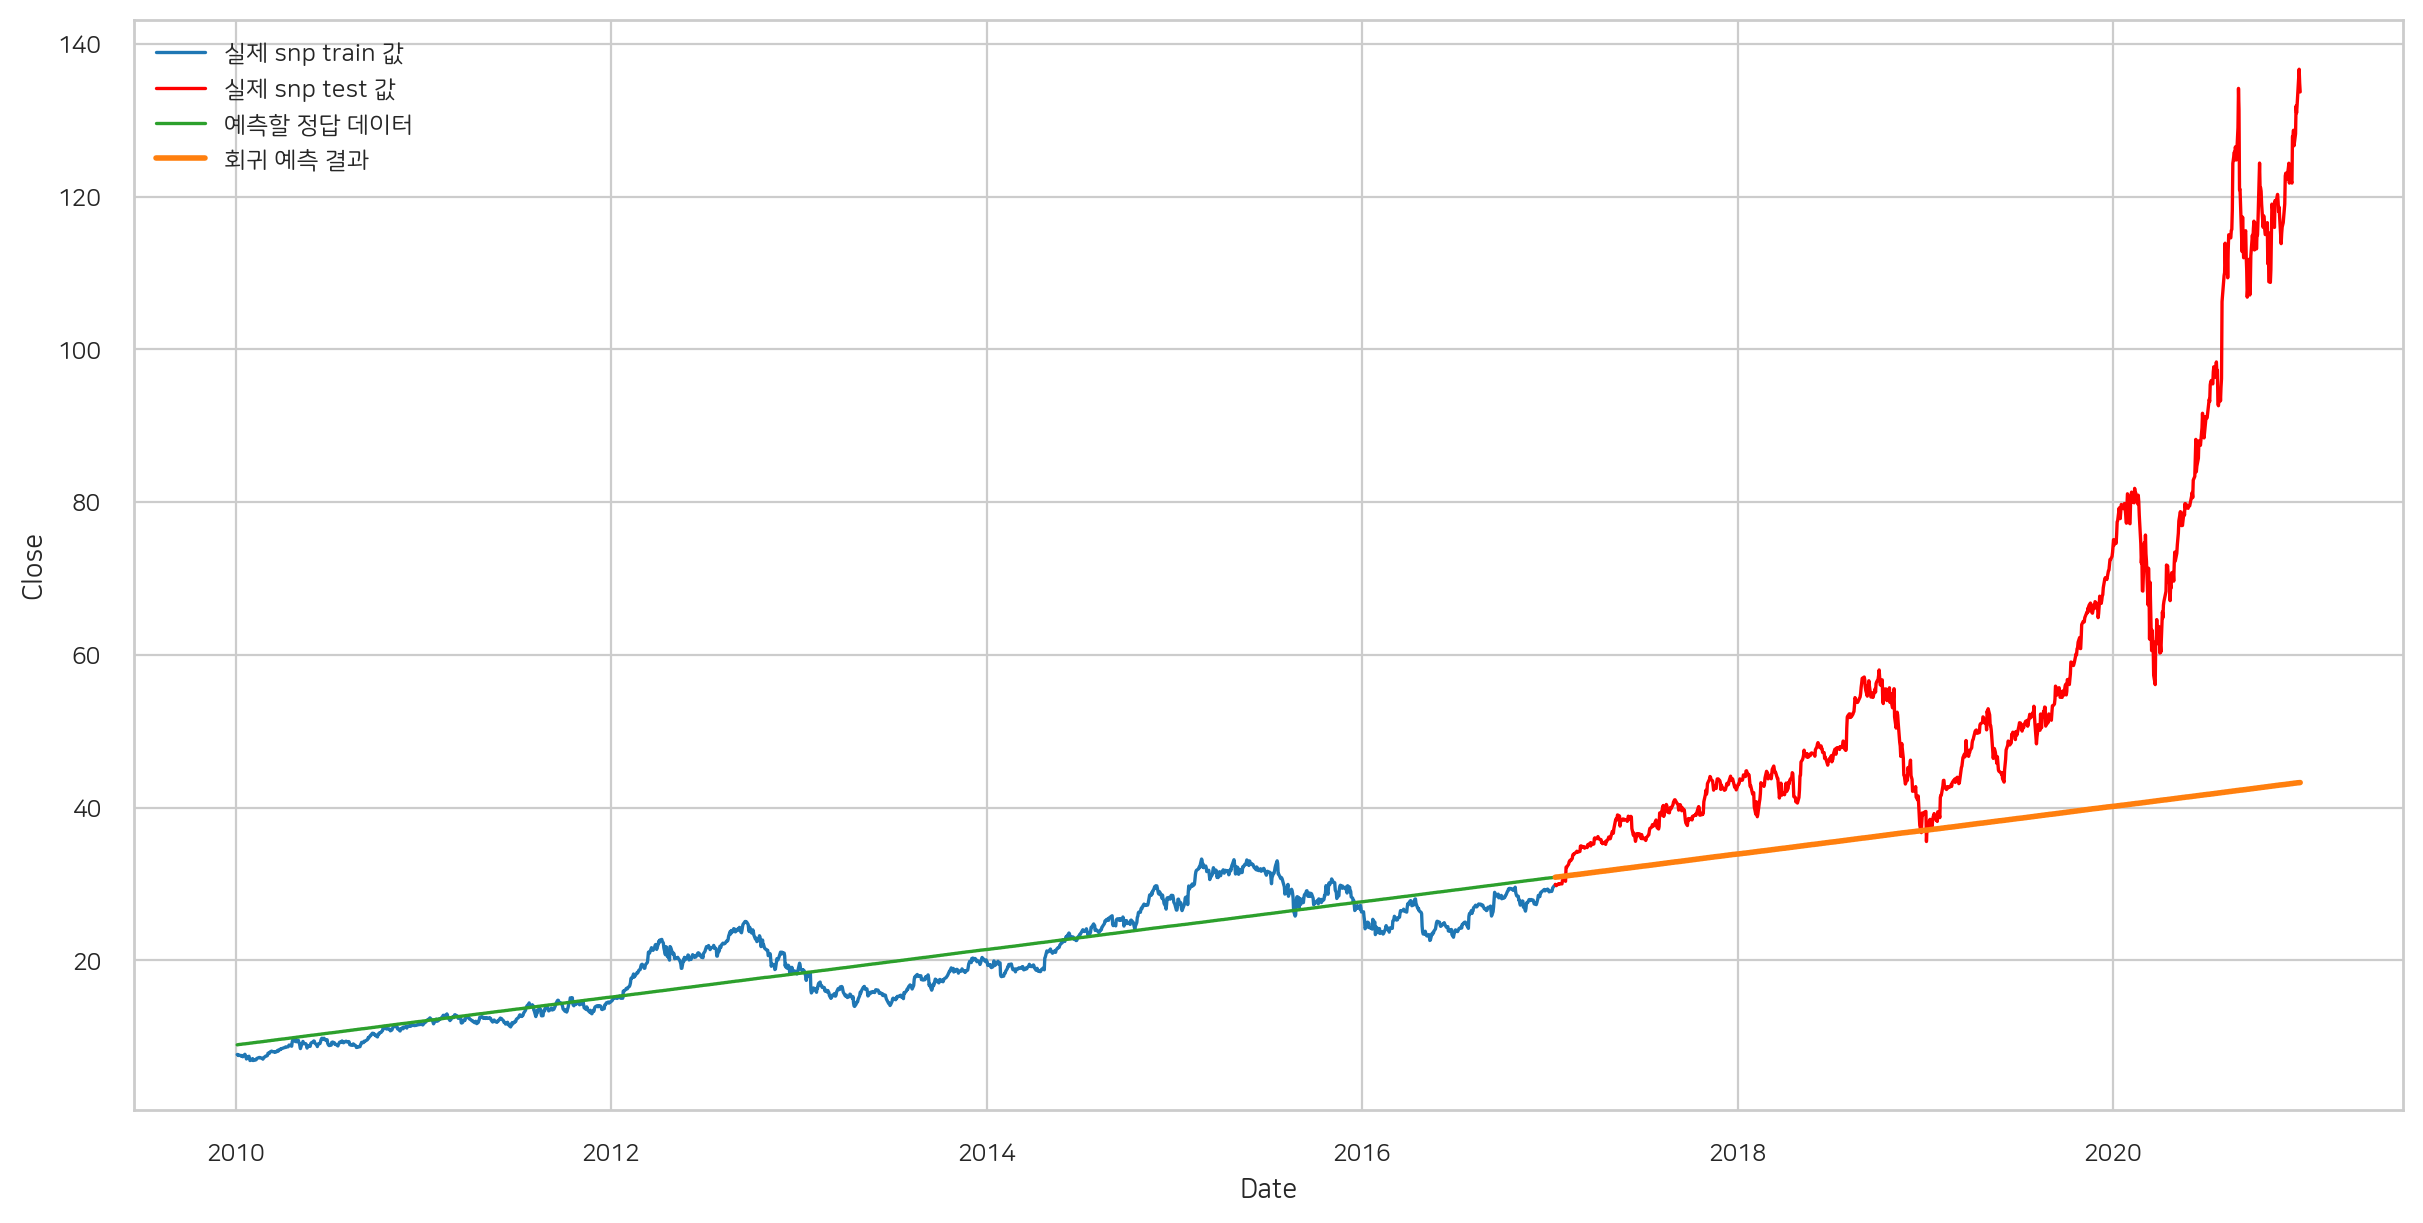

In [5]:
X = close_snp[["index"]]
y = close_snp[["Close"]]



x_train, x_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 1000,
                                                    random_state = 42,
                                                    shuffle=False)



model_1 = LinearRegression()
model_1.fit(x_train, y_train)
pred_train = model_1.predict(x_train)
pred_test = model_1.predict(x_test)



pred_train = pd.Series(pred_train.flatten(), index=y_train.index)
pred_test = pd.Series(pred_test.flatten(), index=y_test.index)



fig, ax = plt.subplots(1,1, figsize=(12,6))

sns.lineplot(data=y_train,
             x = "Date",
             y = "Close",
             color="tab:blue",
             label="실제 snp train 값",)

sns.lineplot(data=y_test,
             x = "Date",
             y = "Close",
             color="red",
             label="실제 snp test 값",)

sns.lineplot(x=y_train.index,
             y=pred_train,
             color="tab:green",
             label="예측할 정답 데이터",)

sns.lineplot(x=y_test.index,
             y=pred_test,
             color="tab:orange",
             linewidth=2,
             label="회귀 예측 결과",);

### 타겟 변환 알고리즘 2 : Tree 모델 종류.

- 조건식 index ≤ 2 일 때 평균 102
- 조건식 index > 2 일 때 평균 103 등
- **예측 값이 데이터 안의 수치를 벗어 날 수 없다.**


In [6]:
model_2 = DecisionTreeRegressor(max_depth=2)
model_2.fit(x_train, y_train)
pred_train_2 = model_2.predict(x_train)
pred_test_2 = model_2.predict(x_test)

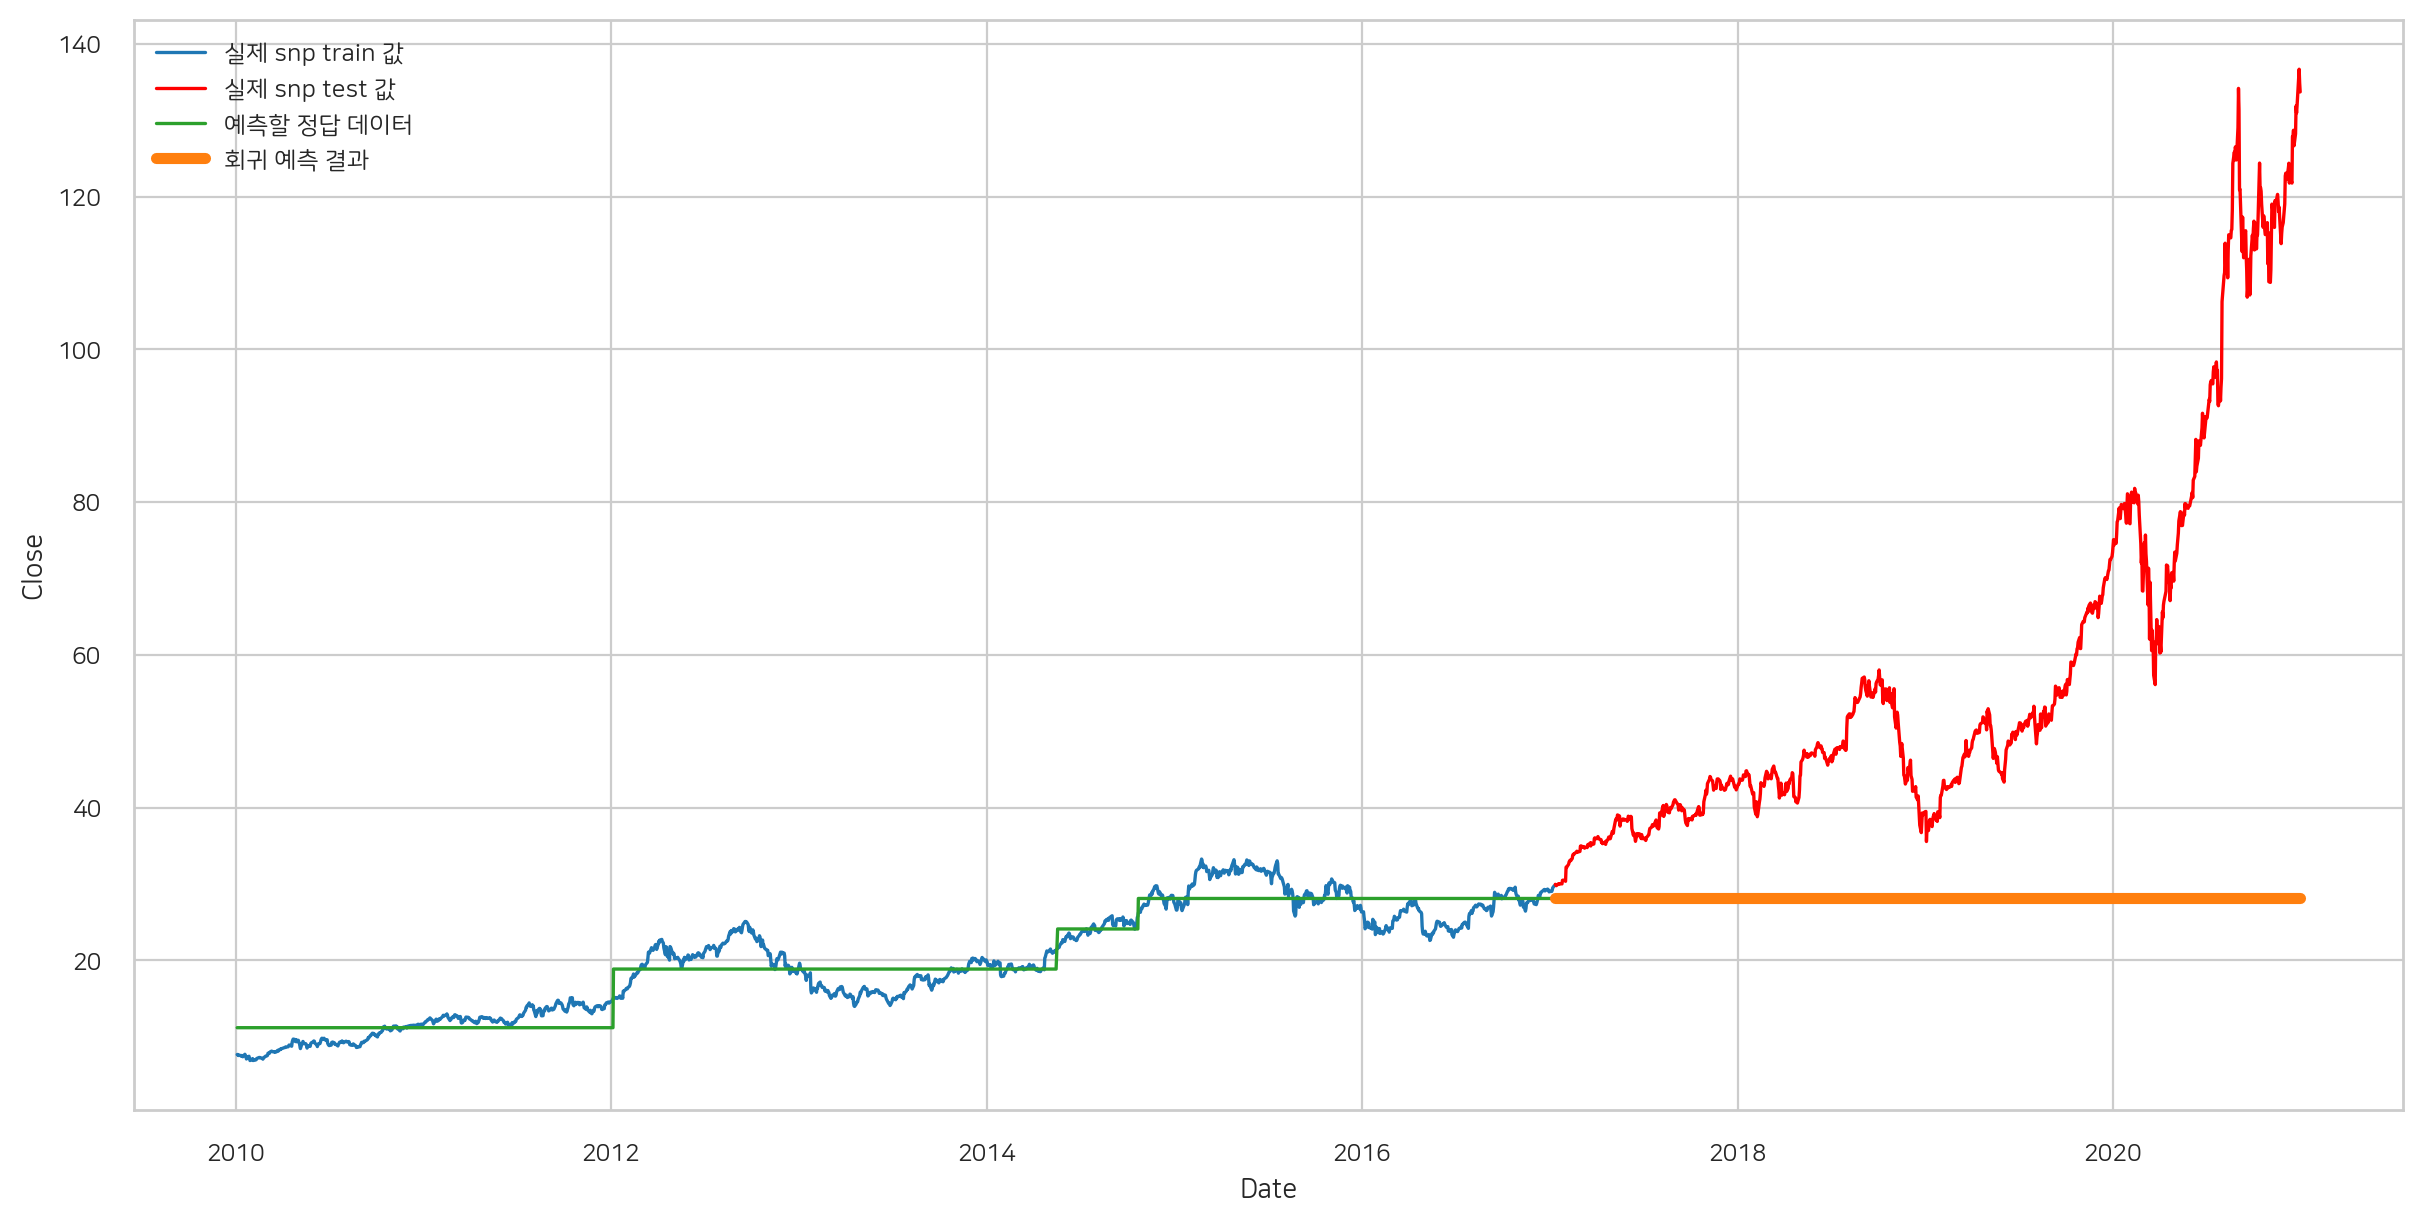

In [7]:
fig, ax = plt.subplots(1,1, figsize=(12,6))

sns.lineplot(data=y_train,
             x = "Date",
             y = "Close",
             color="tab:blue",
             label="실제 snp train 값",)

sns.lineplot(data=y_test,
             x = "Date",
             y = "Close",
             color="red",
             label="실제 snp test 값",)

sns.lineplot(x=y_train.index,
             y=pred_train_2,
             color="tab:green",
             label="예측할 정답 데이터",)

sns.lineplot(x=y_test.index,
             y=pred_test_2,
             color="tab:orange",
             linewidth=4,
             label="회귀 예측 결과",);

### 하이브리드 모델 (Linear Regression + DecisionTreeRegressor 의 잔차 )
Linear Regression 모델은 그대로 사용하고, 트리 모델의 데이터를 Resid ( 잔차로 바꾸어 학습시킨다. )

- 결정트리($y_{\text{pred}}-y$) 잔차 그래프

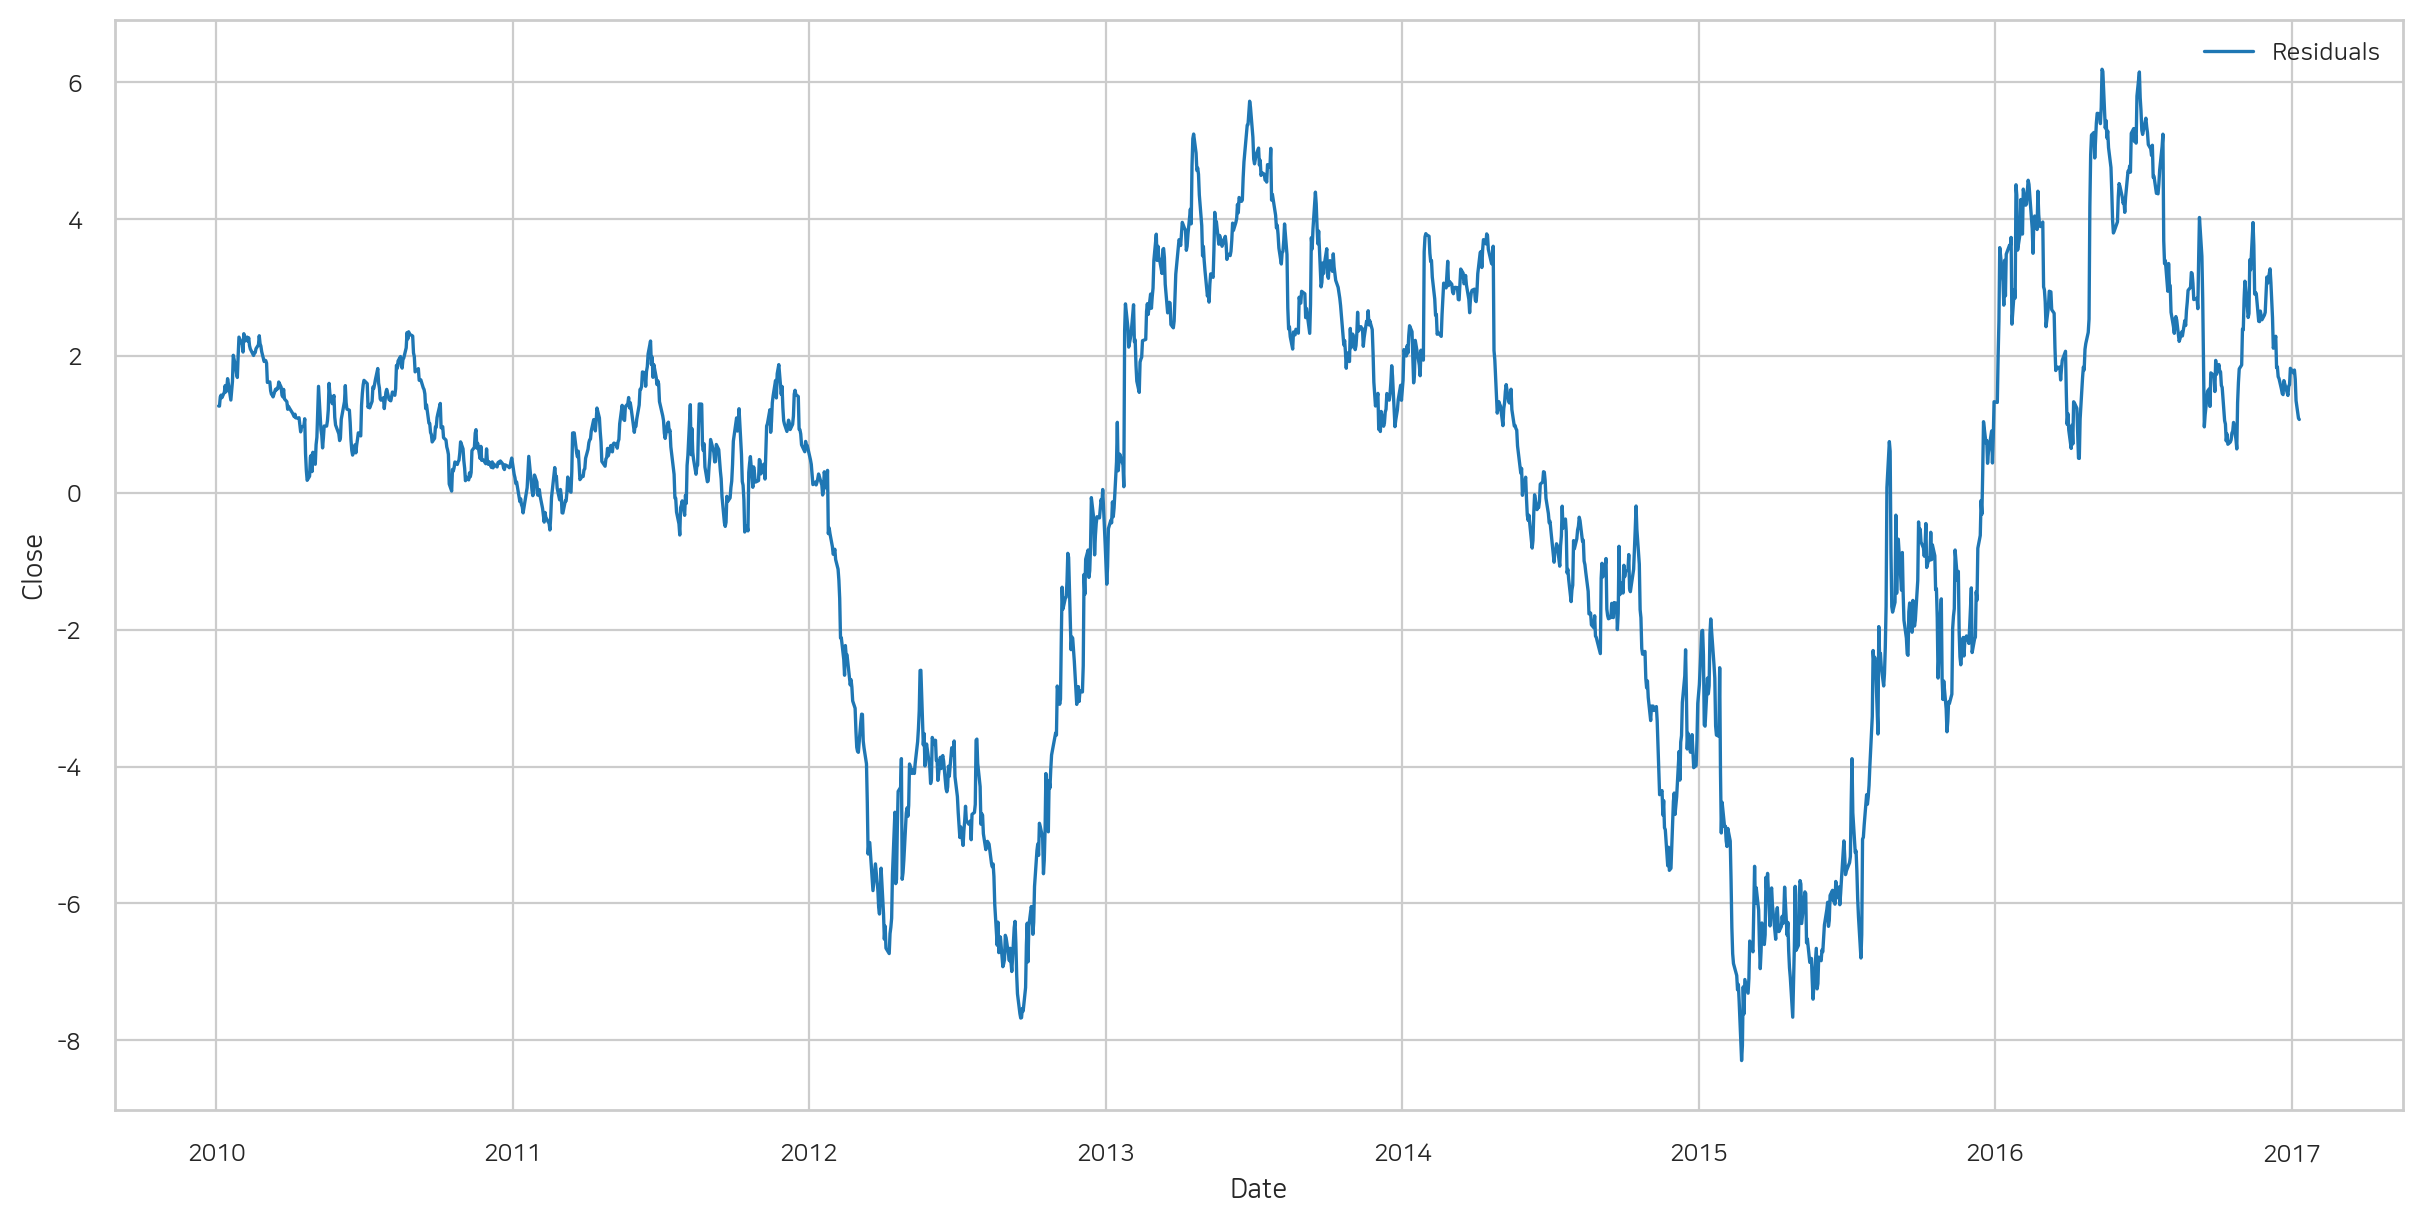

In [8]:
resid = pd.DataFrame(data = pred_train.values,index = pred_train.index,columns= ["Close"])\
    - y_train

fig, ax = plt.subplots(1,1, figsize=(12,6))

sns.lineplot(data=resid,
             x = "Date",
             y = "Close",
             color="tab:blue",
             label="Residuals",);

- 회귀와 잔차에(Linear Regression + DecisionTreeRegressor 의 잔차) 대한 예측 결과


In [9]:
resid.rename(columns={"Close":"resid"}, inplace=True)

In [10]:
model_3 = DecisionTreeRegressor()
model_3.fit(x_train.values,resid[["resid"]])
pred_test_3 = model_3.predict(pd.DataFrame(data=pred_test_2,index=y_test.index,columns=["Close"]) - y_test)
pred_train_3 = model_3.predict(pd.DataFrame(data=pred_train,index=y_train.index,columns=["Close"]) - y_train)

final_pred_train = pred_train - pred_train_3
final_pred_test = pred_test - pred_test_3

/home/tommy/miniconda3/envs/311/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/tommy/miniconda3/envs/311/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


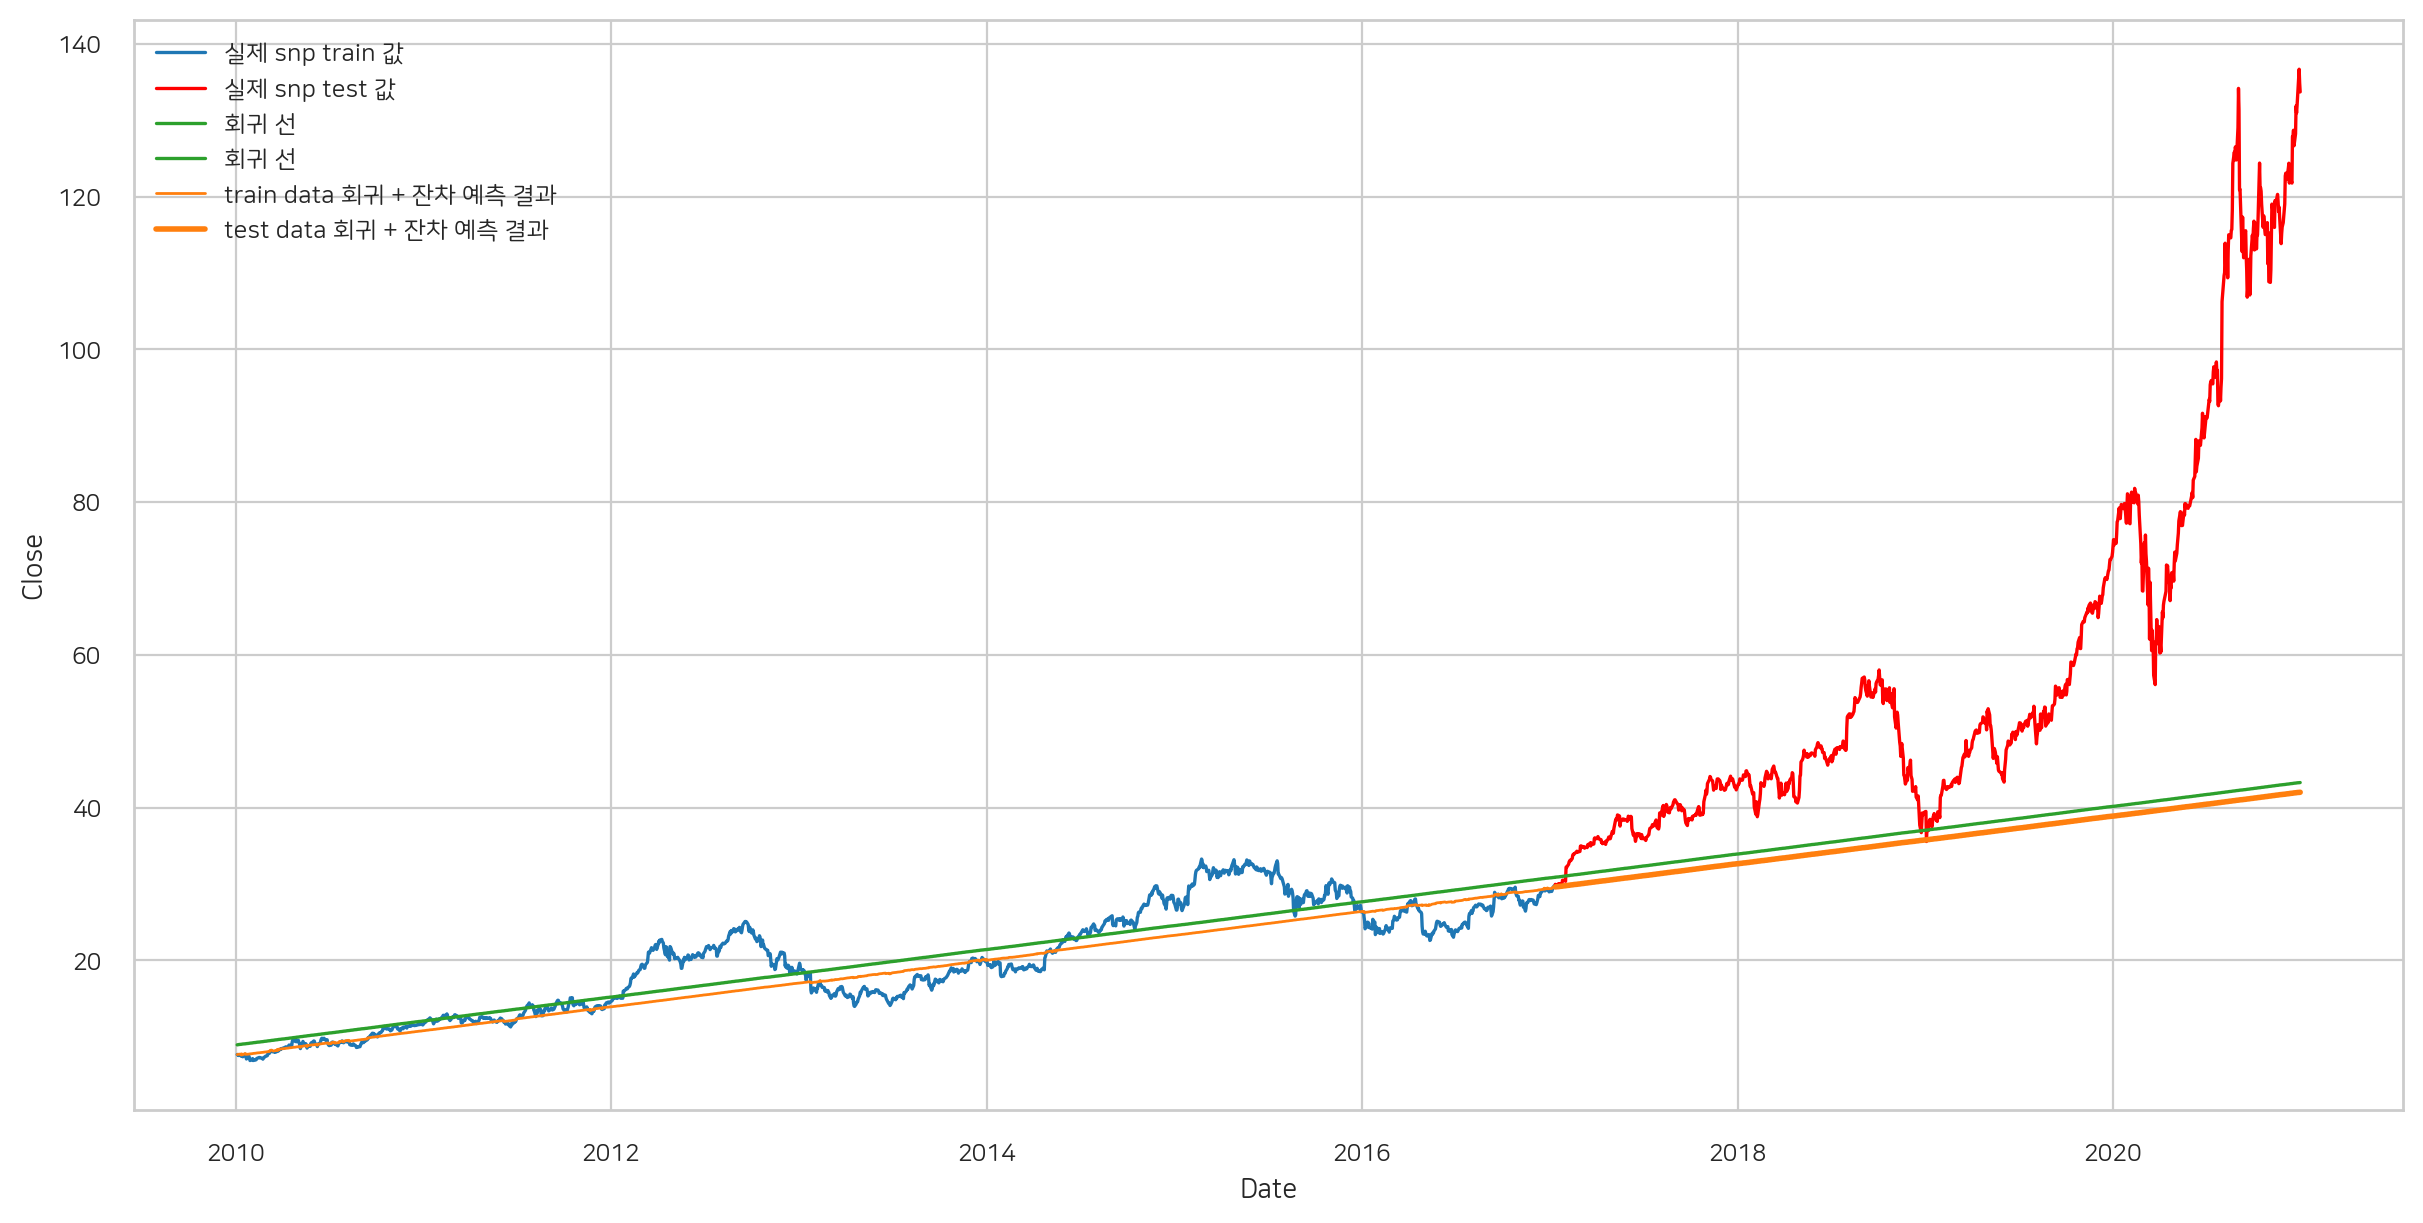

In [11]:
fig, ax = plt.subplots(1,1, figsize=(12,6))

sns.lineplot(data=y_train,
             x = "Date",
             y = "Close",
             color="tab:blue",
             label="실제 snp train 값",)

sns.lineplot(data=y_test,
             x = "Date",
             y = "Close",
             color="red",
             label="실제 snp test 값",)

sns.lineplot(x=y_train.index,
             y=pred_train,
             color="tab:green",
             label="회귀 선",)

sns.lineplot(x=y_test.index,
             y=pred_test,
             color="tab:green",
             label="회귀 선",)

sns.lineplot(x=y_train.index,
             y=final_pred_train,
             color="tab:orange",
             linewidth=1,
             label="train data 회귀 + 잔차 예측 결과",);

sns.lineplot(x=y_test.index,
             y=final_pred_test,
             color="tab:orange",
             linewidth=2,
             label="test data 회귀 + 잔차 예측 결과",);



### 트랜드(다항특성)를 고려하여 잔차와 함께 학습하기
1. trend 에 대한 LinearRegression를 훈련
2. 잔차에 대한 값을 결정 트리를 통해 훈련
3. 여기서 트리의 max_depth 가 너무 많아지면 오버 핏 하여 일반화 기능이 떨어지기 때문에 실험에 의하여 4
    - 특히 LinearRegression 로 선형 적인 부분을 먼저 학습하고
    - 그 이후에 비 선형적인 특징은 결정 트리로 학습을 해 보았다.

In [12]:
y = close_snp[["Close"]]

# 다항 Trand 피쳐 만들기
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=2,
    drop=True,
)

X = dp.in_sample() 

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 0.2,
                                                    shuffle=False)

In [14]:
def drawing_graph(X,pt,xt,tt,xt2):
    fig, ax = plt.subplots(1,1, figsize=(12,6))

    sns.lineplot(data=X,
                 x = "Date",
                 y = "Close",
                 color="red",
                 label="실제 snp test 값",ax=ax)

    sns.lineplot(x=xt.index,
                 y=pt.flatten(),
                 color="tab:green",
                 alpha = 0.8,
                 linewidth = 3,
                 label="예측 데이터",ax=ax)
    sns.lineplot(x=xt2.index,
                 y=tt.flatten(),
                 alpha = 1,
                 color="tab:orange",
                 linewidth = 3,
                 label="예측 데이터",ax=ax)

- trand 의 학습 (2차 다항식)

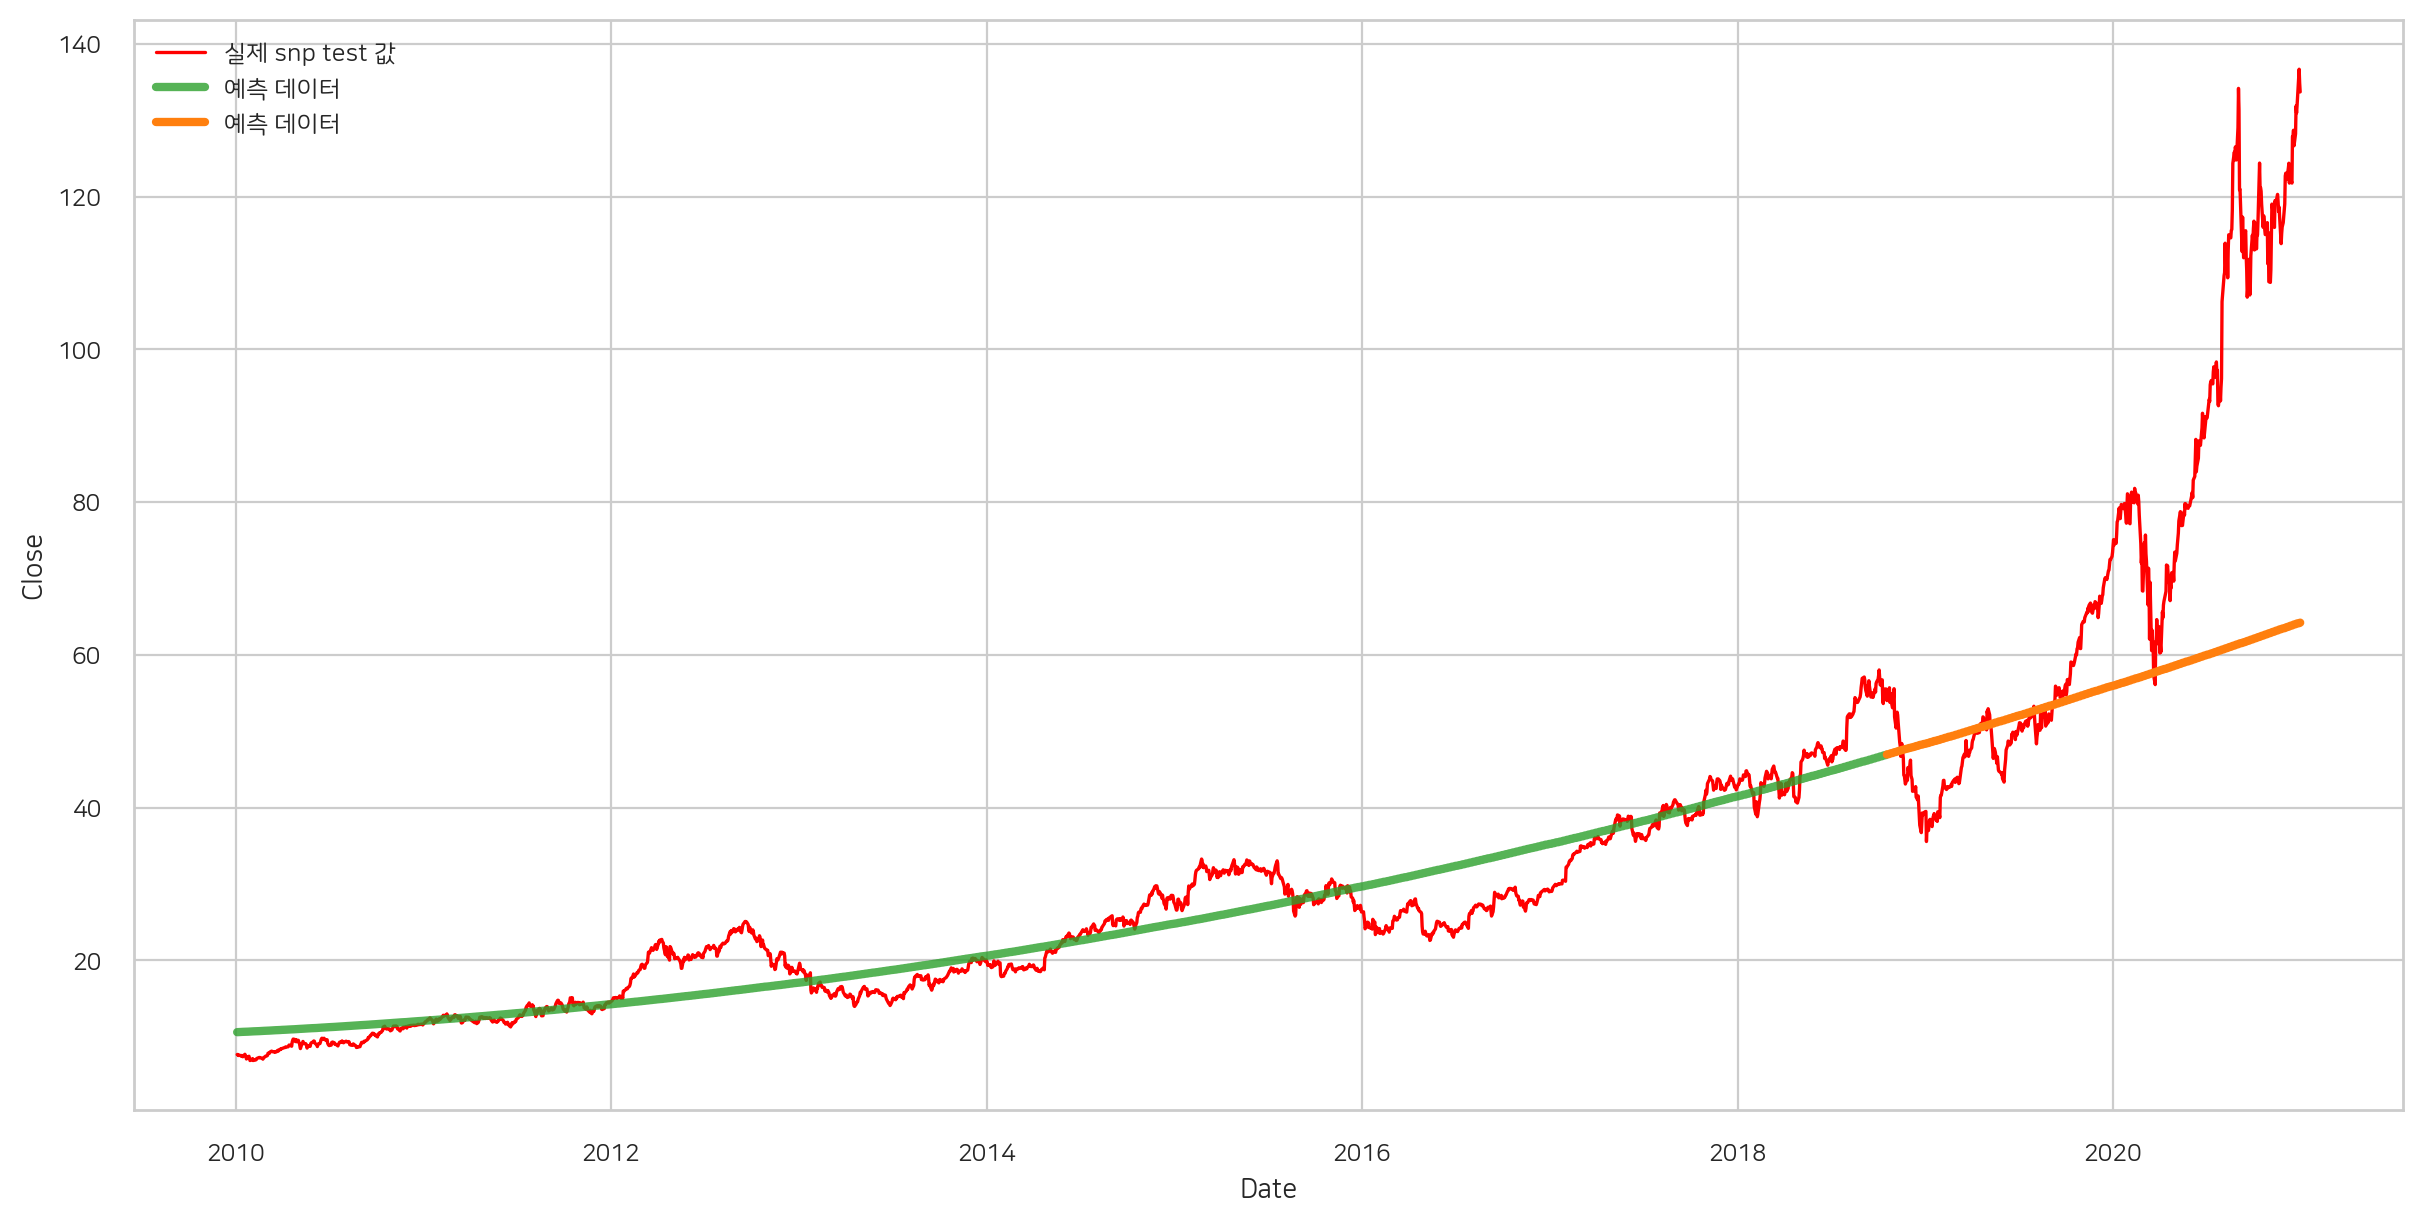

In [15]:
model_trend = LinearRegression()
model_trend.fit(x_train, y_train)
trend_pred_train = model_trend.predict(x_train)
trend_pred_test = model_trend.predict(x_test)
drawing_graph(snp_500,trend_pred_train,x_train,trend_pred_test,x_test)

- resid 에 대한 학습 (DecisionTreeRegressor) 을 이용

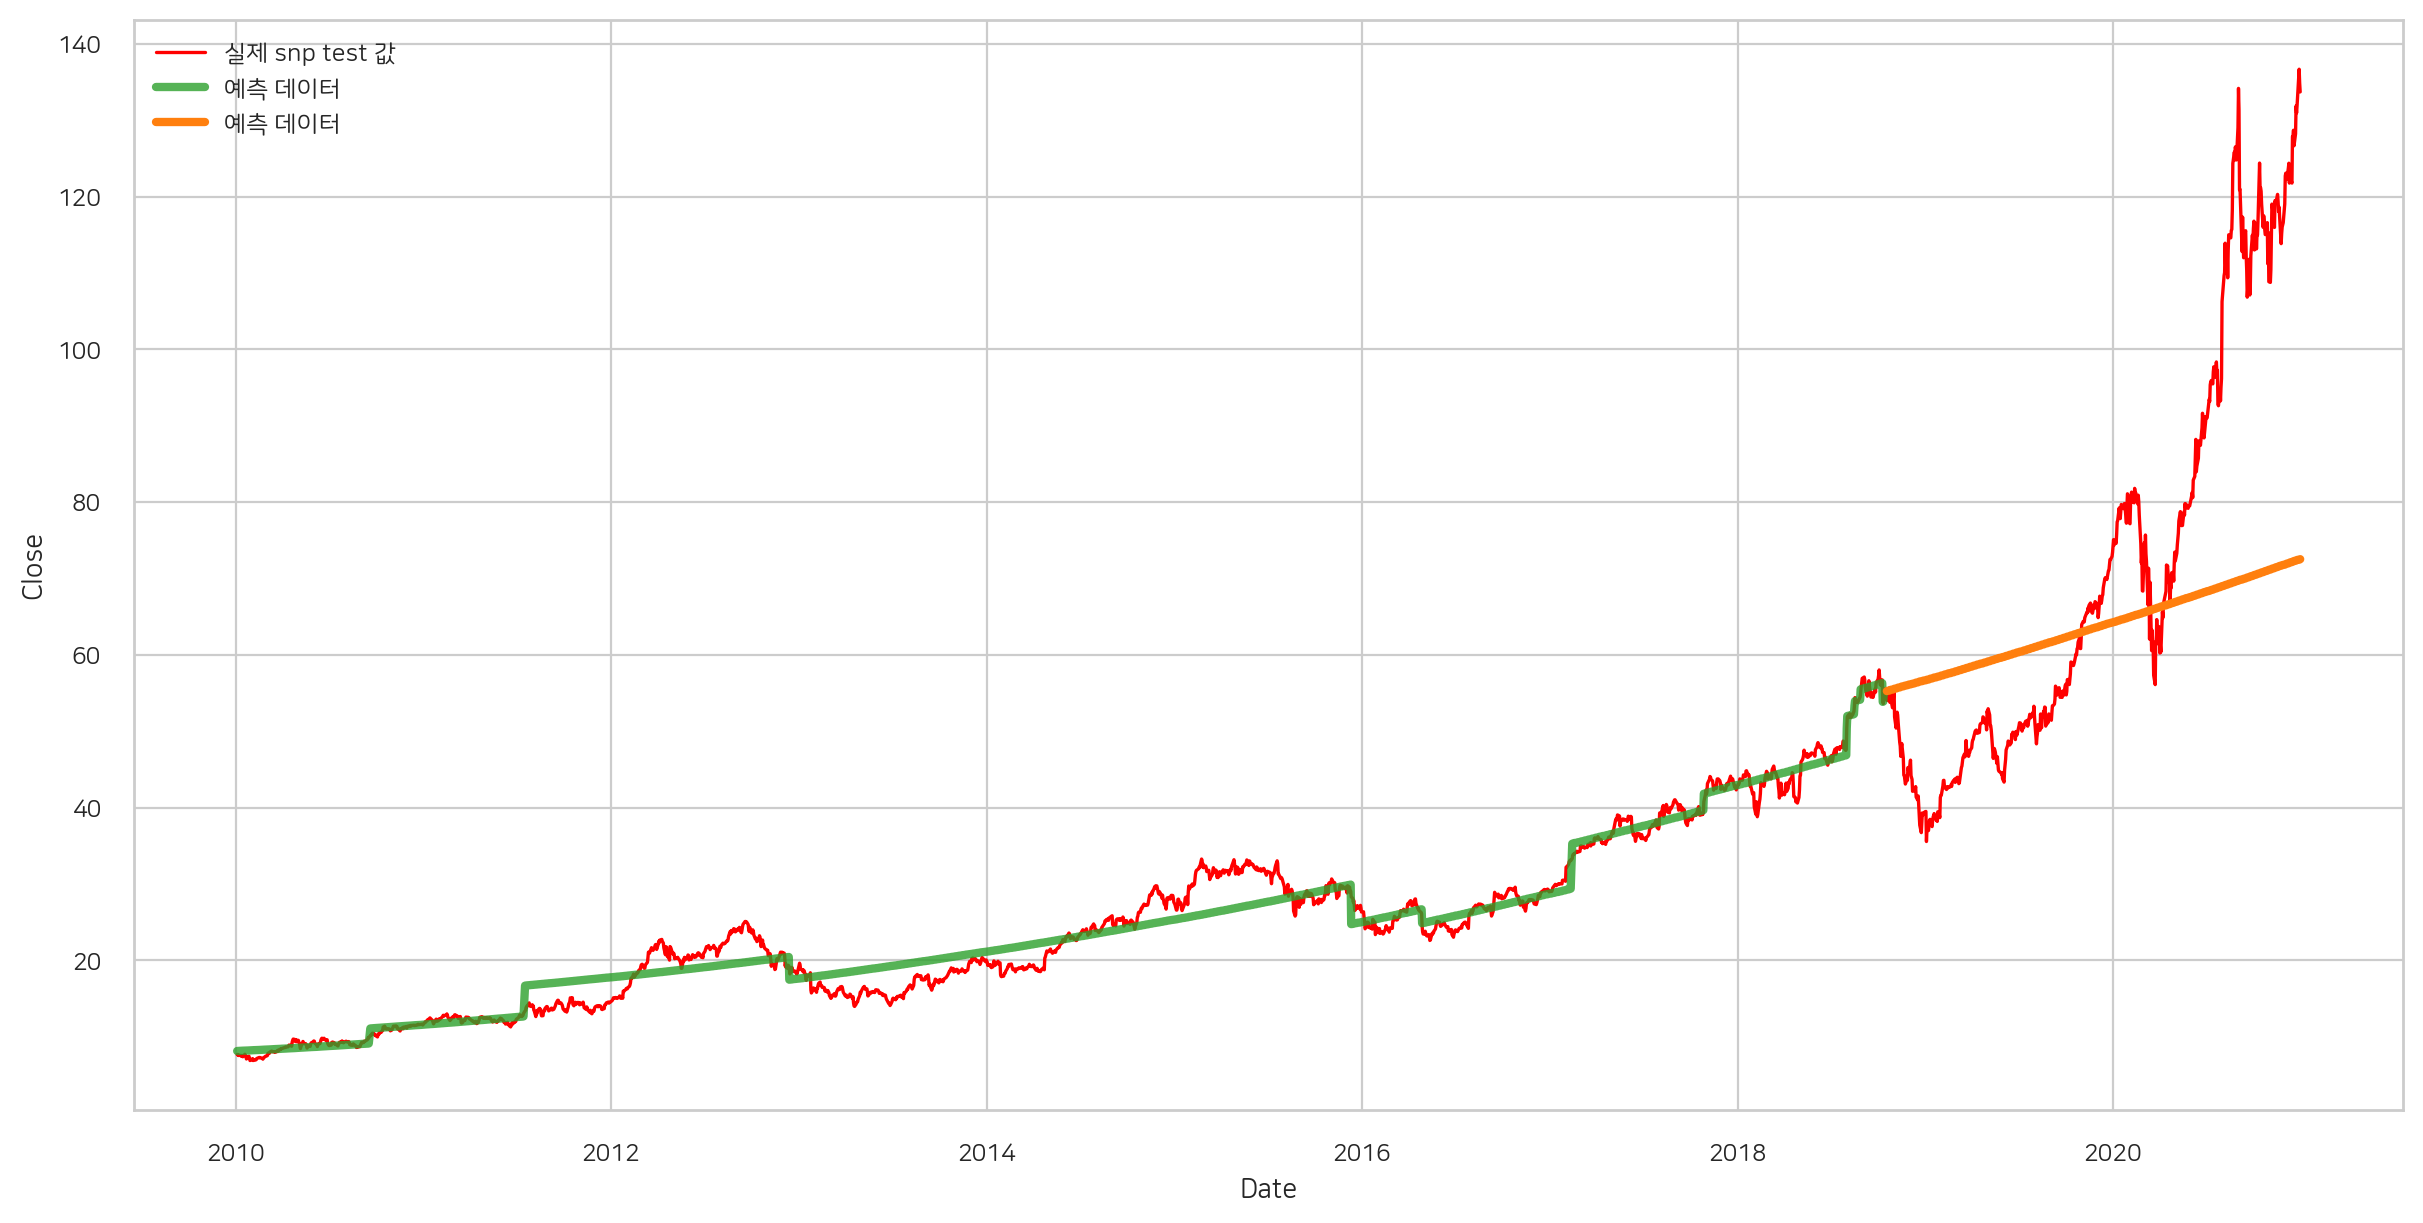

In [16]:
resid_train = y_train - trend_pred_train
model_tree = DecisionTreeRegressor(max_depth=4)
model_tree.fit(x_train,resid_train)
pred_fin_train = model_tree.predict(x_train) + trend_pred_train.reshape(2214,)
pred_fin_test = model_tree.predict(x_test) + trend_pred_test.reshape(554,)

drawing_graph(snp_500,pred_fin_train,x_train,pred_fin_test,x_test)